<a href="https://colab.research.google.com/github/stevanzecic/WeatherPredict/blob/main/Copy_of_Delhi_Weather_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATASET**

In [ ]:
import tensorflow as tf
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from keras.models import Sequential
from keras.models import load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import Flatten
from keras.layers import TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout
from keras.layers import LSTM
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from scipy.interpolate import interp1d


In [ ]:
!cp "/content/drive/MyDrive/III/Neuronske mreže/Domaći zadatak/testset.csv" "/content/delhiweatherdata.csv"


In [ ]:
input_path = '/content/delhiweatherdata.csv'
input_data = pd.read_csv(input_path)
input_data

,datetime_utc,_conds,_dewptm,_fog,_hail,_heatindexm,_hum,_precipm,_pressurem,_rain,_snow,_tempm,_thunder,_tornado,_vism,_wdird,_wdire,_wgustm,_windchillm,_wspdm
0,19961101-11:00,Smoke,9.0,0,0,NaN,27.0,NaN,1010.0,0,0,30.0,0,0,5.0,280.0,West,NaN,NaN,7.4
1,19961101-12:00,Smoke,10.0,0,0,NaN,32.0,NaN,-9999.0,0,0,28.0,0,0,NaN,0.0,North,NaN,NaN,NaN
2,19961101-13:00,Smoke,11.0,0,0,NaN,44.0,NaN,-9999.0,0,0,24.0,0,0,NaN,0.0,North,NaN,NaN,NaN
3,19961101-14:00,Smoke,10.0,0,0,NaN,41.0,NaN,1010.0,0,0,24.0,0,0,2.0,0.0,North,NaN,NaN,NaN
4,19961101-16:00,Smoke,11.0,0,0,NaN,47.0,NaN,1011.0,0,0,23.0,0,0,1.2,0.0,North,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100985,20170424-06:00,Haze,17.0,0,0,NaN,25.0,NaN,1005.0,0,0,34.0,0,0,4.0,320.0,NW,NaN,NaN,11.1
100986,20170424-09:00,Haze,14.0,0,0,NaN,16.0,NaN,1003.0,0,0,38.0,0,0,4.0,320.0,NW,NaN,NaN,22.2
100987,20170424-12:00,Haze,12.0,0,0,NaN,14.0,NaN,1002.0,0,0,36.0,0,0,4.0,270.0,West,NaN,NaN,18.5
100988,20170424-15:00,Haze,15.0,0,0,NaN,27.0,NaN,1004.0,0,0,32.0,0,0,2.0,320.0,NW,NaN,NaN,3.7


In [ ]:
input_data.columns

Index(['datetime_utc', ' _conds', ' _dewptm', ' _fog', ' _hail',
       ' _heatindexm', ' _hum', ' _precipm', ' _pressurem', ' _rain', ' _snow',
       ' _tempm', ' _thunder', ' _tornado', ' _vism', ' _wdird', ' _wdire',
       ' _wgustm', ' _windchillm', ' _wspdm'],
      dtype='object')

In [ ]:
#Za dosta unosa fali vrednost temperature, ovde se interpolacijom dodaju vrednosti koje fale

#input_data[' _tempm'].fillna(input_data[' _tempm'].mean(), inplace = True)
input_data[' _tempm'] = input_data[' _tempm'].interpolate()

0         30.0
1         28.0
2         24.0
3         24.0
4         23.0
          ... 
100985    34.0
100986    38.0
100987    36.0
100988    32.0
100989    30.0
Name:  _tempm, Length: 100990, dtype: float64

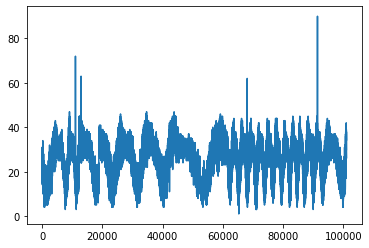

In [ ]:
temp = input_data[' _tempm']
temp.plot()
temp

In [ ]:
def input_data_to_X_y(input_data, window_size = 5):
  input_data_as_np = input_data.to_numpy()
  X = []
  y = []
  for i in range(len(input_data_as_np) - window_size):
    row = [[j] for j in input_data_as_np[i : i + window_size]]
    X.append(row)
    label = input_data_as_np[i + window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE = 30
X, y = input_data_to_X_y(temp, WINDOW_SIZE)
X.shape, y.shape

((100960, 30, 1), (100960,))

In [ ]:
#X_train, y_train = X[:80788], y[:80788]
#X_val, y_val = X[80788:90886], y[80788:90886]
#X_test, y_test = X[90886:], y[90886:]
#X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

# **MODEL 1 - LSTM**

In [ ]:
X_train1, y_train1 = X[:80788], y[:80788]
X_val1, y_val1 = X[80788:90886], y[80788:90886]
X_test1, y_test1 = X[90886:], y[90886:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((80788, 30, 1), (80788,), (10098, 30, 1), (10098,), (10074, 30, 1), (10074,))

In [ ]:
model1 = Sequential()
model1.add(InputLayer((30, 1)))
model1.add(LSTM(64))
#model1.add(Dense(32, 'relu'))
#model1.add(Dense(32, 'relu'))
model1.add(Dense(32, 'relu'))
model1.add(Dense(16, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 64)                16896     
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 19,521
Trainable params: 19,521
Non-trainable params: 0
_________________________________________________________________


In [ ]:
chp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
history1 = model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=200, callbacks=[chp1])

Epoch 1/200
2525/2525 [==============================] - ETA: 0s - loss: 77.0904 - root_mean_squared_error: 8.7801

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 47s 18ms/step - loss: 77.0904 - root_mean_squared_error: 8.7801 - val_loss: 11.0848 - val_root_mean_squared_error: 3.3294
Epoch 2/200
2525/2525 [==============================] - ETA: 0s - loss: 4.2645 - root_mean_squared_error: 2.0651

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 40s 16ms/step - loss: 4.2645 - root_mean_squared_error: 2.0651 - val_loss: 10.6676 - val_root_mean_squared_error: 3.2661
Epoch 3/200
2525/2525 [==============================] - ETA: 0s - loss: 3.9999 - root_mean_squared_error: 2.0000

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 3.9999 - root_mean_squared_error: 2.0000 - val_loss: 9.6824 - val_root_mean_squared_error: 3.1117
Epoch 4/200
2525/2525 [==============================] - ETA: 0s - loss: 3.3662 - root_mean_squared_error: 1.8347

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 3.3662 - root_mean_squared_error: 1.8347 - val_loss: 7.9163 - val_root_mean_squared_error: 2.8136
Epoch 5/200
2525/2525 [==============================] - ETA: 0s - loss: 2.7472 - root_mean_squared_error: 1.6575

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 43s 17ms/step - loss: 2.7472 - root_mean_squared_error: 1.6575 - val_loss: 7.7308 - val_root_mean_squared_error: 2.7804
Epoch 6/200
2523/2525 [============================>.] - ETA: 0s - loss: 2.5719 - root_mean_squared_error: 1.6037

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.5717 - root_mean_squared_error: 1.6037 - val_loss: 7.3182 - val_root_mean_squared_error: 2.7052
Epoch 7/200
2523/2525 [============================>.] - ETA: 0s - loss: 2.5010 - root_mean_squared_error: 1.5815

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.5006 - root_mean_squared_error: 1.5813 - val_loss: 7.1409 - val_root_mean_squared_error: 2.6722
Epoch 8/200
2524/2525 [============================>.] - ETA: 0s - loss: 2.4578 - root_mean_squared_error: 1.5677

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 17ms/step - loss: 2.4574 - root_mean_squared_error: 1.5676 - val_loss: 7.0972 - val_root_mean_squared_error: 2.6641
Epoch 9/200
2525/2525 [==============================] - ETA: 0s - loss: 2.4252 - root_mean_squared_error: 1.5573

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 45s 18ms/step - loss: 2.4252 - root_mean_squared_error: 1.5573 - val_loss: 6.9779 - val_root_mean_squared_error: 2.6416
Epoch 10/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.3981 - root_mean_squared_error: 1.5486 - val_loss: 7.0808 - val_root_mean_squared_error: 2.6610
Epoch 11/200
2522/2525 [============================>.] - ETA: 0s - loss: 2.3763 - root_mean_squared_error: 1.5415

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.3759 - root_mean_squared_error: 1.5414 - val_loss: 6.7956 - val_root_mean_squared_error: 2.6068
Epoch 12/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.3638 - root_mean_squared_error: 1.5375 - val_loss: 6.8546 - val_root_mean_squared_error: 2.6181
Epoch 13/200
2524/2525 [============================>.] - ETA: 0s - loss: 2.3432 - root_mean_squared_error: 1.5307

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 44s 17ms/step - loss: 2.3428 - root_mean_squared_error: 1.5306 - val_loss: 6.7821 - val_root_mean_squared_error: 2.6043
Epoch 14/200
2525/2525 [==============================] - ETA: 0s - loss: 2.3356 - root_mean_squared_error: 1.5283

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 43s 17ms/step - loss: 2.3356 - root_mean_squared_error: 1.5283 - val_loss: 6.7573 - val_root_mean_squared_error: 2.5995
Epoch 15/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.3222 - root_mean_squared_error: 1.5239 - val_loss: 6.8491 - val_root_mean_squared_error: 2.6171
Epoch 16/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.3057 - root_mean_squared_error: 1.5185 - val_loss: 6.8006 - val_root_mean_squared_error: 2.6078
Epoch 17/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.2981 - root_mean_squared_error: 1.5160 - val_loss: 6.8587 - val_root_mean_squared_error: 2.6189
Epoch 18/200
2524/2525 [============================>.] - ETA: 0s - loss: 2.2960 - root_mean_squared_error: 1.5153

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 44s 17ms/step - loss: 2.2958 - root_mean_squared_error: 1.5152 - val_loss: 6.5304 - val_root_mean_squared_error: 2.5555
Epoch 19/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.2879 - root_mean_squared_error: 1.5126 - val_loss: 6.6790 - val_root_mean_squared_error: 2.5844
Epoch 20/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.2770 - root_mean_squared_error: 1.5090 - val_loss: 6.5875 - val_root_mean_squared_error: 2.5666
Epoch 21/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.2686 - root_mean_squared_error: 1.5062 - val_loss: 6.5973 - val_root_mean_squared_error: 2.5685
Epoch 22/200
2525/2525 [==============================] - 39s 15ms/step - loss: 2.2594 - root_mean_squared_error: 1.5031 - val_loss: 6.5481 - val_root_mean_squared_error: 2.5589
Epoch 23/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.2590 - root_mean_squared_error: 1.5030 - 

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 16ms/step - loss: 2.2299 - root_mean_squared_error: 1.4933 - val_loss: 6.4227 - val_root_mean_squared_error: 2.5343
Epoch 29/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.2250 - root_mean_squared_error: 1.4916 - val_loss: 6.4871 - val_root_mean_squared_error: 2.5470
Epoch 30/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.2186 - root_mean_squared_error: 1.4895 - val_loss: 6.5308 - val_root_mean_squared_error: 2.5555
Epoch 31/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.2081 - root_mean_squared_error: 1.4860 - val_loss: 6.4409 - val_root_mean_squared_error: 2.5379
Epoch 32/200
2522/2525 [============================>.] - ETA: 0s - loss: 2.2081 - root_mean_squared_error: 1.4860

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.2087 - root_mean_squared_error: 1.4862 - val_loss: 6.3391 - val_root_mean_squared_error: 2.5178
Epoch 33/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1983 - root_mean_squared_error: 1.4827 - val_loss: 6.5620 - val_root_mean_squared_error: 2.5616
Epoch 34/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.2004 - root_mean_squared_error: 1.4834 - val_loss: 6.4714 - val_root_mean_squared_error: 2.5439
Epoch 35/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1893 - root_mean_squared_error: 1.4796 - val_loss: 6.4368 - val_root_mean_squared_error: 2.5371
Epoch 36/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1833 - root_mean_squared_error: 1.4776 - val_loss: 6.3881 - val_root_mean_squared_error: 2.5275
Epoch 37/200
2523/2525 [============================>.] - ETA: 0s - loss: 2.1805 - root_mean_squared_error: 1.4767

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 16ms/step - loss: 2.1800 - root_mean_squared_error: 1.4765 - val_loss: 6.3289 - val_root_mean_squared_error: 2.5157
Epoch 38/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1754 - root_mean_squared_error: 1.4749 - val_loss: 6.4049 - val_root_mean_squared_error: 2.5308
Epoch 39/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1681 - root_mean_squared_error: 1.4725 - val_loss: 6.3646 - val_root_mean_squared_error: 2.5228
Epoch 40/200
2522/2525 [============================>.] - ETA: 0s - loss: 2.1736 - root_mean_squared_error: 1.4743

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.1735 - root_mean_squared_error: 1.4743 - val_loss: 6.2702 - val_root_mean_squared_error: 2.5040
Epoch 41/200
2523/2525 [============================>.] - ETA: 0s - loss: 2.1630 - root_mean_squared_error: 1.4707

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 43s 17ms/step - loss: 2.1625 - root_mean_squared_error: 1.4705 - val_loss: 6.2603 - val_root_mean_squared_error: 2.5021
Epoch 42/200
2524/2525 [============================>.] - ETA: 0s - loss: 2.1605 - root_mean_squared_error: 1.4699

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.1613 - root_mean_squared_error: 1.4701 - val_loss: 6.2490 - val_root_mean_squared_error: 2.4998
Epoch 43/200
2525/2525 [==============================] - ETA: 0s - loss: 2.1605 - root_mean_squared_error: 1.4698

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 16ms/step - loss: 2.1605 - root_mean_squared_error: 1.4698 - val_loss: 6.2017 - val_root_mean_squared_error: 2.4903
Epoch 44/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1533 - root_mean_squared_error: 1.4674 - val_loss: 6.2625 - val_root_mean_squared_error: 2.5025
Epoch 45/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1548 - root_mean_squared_error: 1.4679 - val_loss: 6.3126 - val_root_mean_squared_error: 2.5125
Epoch 46/200
2525/2525 [==============================] - 39s 15ms/step - loss: 2.1474 - root_mean_squared_error: 1.4654 - val_loss: 6.2933 - val_root_mean_squared_error: 2.5086
Epoch 47/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1464 - root_mean_squared_error: 1.4650 - val_loss: 6.3227 - val_root_mean_squared_error: 2.5145
Epoch 48/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1416 - root_mean_squared_error: 1.4634 - 

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.1315 - root_mean_squared_error: 1.4600 - val_loss: 6.1897 - val_root_mean_squared_error: 2.4879
Epoch 52/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1269 - root_mean_squared_error: 1.4584 - val_loss: 6.4412 - val_root_mean_squared_error: 2.5379
Epoch 53/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1242 - root_mean_squared_error: 1.4575 - val_loss: 6.2160 - val_root_mean_squared_error: 2.4932
Epoch 54/200
2524/2525 [============================>.] - ETA: 0s - loss: 2.1199 - root_mean_squared_error: 1.4560

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.1197 - root_mean_squared_error: 1.4559 - val_loss: 6.1363 - val_root_mean_squared_error: 2.4772
Epoch 55/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.1189 - root_mean_squared_error: 1.4556 - val_loss: 6.1605 - val_root_mean_squared_error: 2.4820
Epoch 56/200
2525/2525 [==============================] - ETA: 0s - loss: 2.1144 - root_mean_squared_error: 1.4541

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.1144 - root_mean_squared_error: 1.4541 - val_loss: 6.1303 - val_root_mean_squared_error: 2.4759
Epoch 57/200
2522/2525 [============================>.] - ETA: 0s - loss: 2.1090 - root_mean_squared_error: 1.4522

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.1086 - root_mean_squared_error: 1.4521 - val_loss: 6.1149 - val_root_mean_squared_error: 2.4728
Epoch 58/200
2522/2525 [============================>.] - ETA: 0s - loss: 2.1091 - root_mean_squared_error: 1.4523

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.1092 - root_mean_squared_error: 1.4523 - val_loss: 6.0804 - val_root_mean_squared_error: 2.4659
Epoch 59/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.1057 - root_mean_squared_error: 1.4511 - val_loss: 6.1301 - val_root_mean_squared_error: 2.4759
Epoch 60/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0970 - root_mean_squared_error: 1.4481 - val_loss: 6.2036 - val_root_mean_squared_error: 2.4907
Epoch 61/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.1018 - root_mean_squared_error: 1.4498 - val_loss: 6.1080 - val_root_mean_squared_error: 2.4714
Epoch 62/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0991 - root_mean_squared_error: 1.4488 - val_loss: 6.1301 - val_root_mean_squared_error: 2.4759
Epoch 63/200
2525/2525 [==============================] - 39s 15ms/step - loss: 2.0971 - root_mean_squared_error: 1.4481 - 

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 17ms/step - loss: 2.0859 - root_mean_squared_error: 1.4443 - val_loss: 6.0557 - val_root_mean_squared_error: 2.4608
Epoch 67/200
2524/2525 [============================>.] - ETA: 0s - loss: 2.0822 - root_mean_squared_error: 1.4430

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 17ms/step - loss: 2.0819 - root_mean_squared_error: 1.4429 - val_loss: 5.9937 - val_root_mean_squared_error: 2.4482
Epoch 68/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0814 - root_mean_squared_error: 1.4427 - val_loss: 6.1604 - val_root_mean_squared_error: 2.4820
Epoch 69/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0781 - root_mean_squared_error: 1.4416 - val_loss: 6.0349 - val_root_mean_squared_error: 2.4566
Epoch 70/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0755 - root_mean_squared_error: 1.4407 - val_loss: 6.0584 - val_root_mean_squared_error: 2.4614
Epoch 71/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0714 - root_mean_squared_error: 1.4392 - val_loss: 6.0779 - val_root_mean_squared_error: 2.4653
Epoch 72/200
2525/2525 [==============================] - ETA: 0s - loss: 2.0684 - root_mean_squared_error: 1.4382

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 44s 17ms/step - loss: 2.0684 - root_mean_squared_error: 1.4382 - val_loss: 5.9655 - val_root_mean_squared_error: 2.4424
Epoch 73/200
2523/2525 [============================>.] - ETA: 0s - loss: 2.0669 - root_mean_squared_error: 1.4377

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 17ms/step - loss: 2.0668 - root_mean_squared_error: 1.4376 - val_loss: 5.9554 - val_root_mean_squared_error: 2.4404
Epoch 74/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.0648 - root_mean_squared_error: 1.4369 - val_loss: 6.0013 - val_root_mean_squared_error: 2.4498
Epoch 75/200
2523/2525 [============================>.] - ETA: 0s - loss: 2.0643 - root_mean_squared_error: 1.4368

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 43s 17ms/step - loss: 2.0640 - root_mean_squared_error: 1.4367 - val_loss: 5.9493 - val_root_mean_squared_error: 2.4391
Epoch 76/200
2525/2525 [==============================] - 39s 15ms/step - loss: 2.0632 - root_mean_squared_error: 1.4364 - val_loss: 6.0028 - val_root_mean_squared_error: 2.4501
Epoch 77/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.0579 - root_mean_squared_error: 1.4345 - val_loss: 6.0700 - val_root_mean_squared_error: 2.4637
Epoch 78/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.0550 - root_mean_squared_error: 1.4335 - val_loss: 6.1599 - val_root_mean_squared_error: 2.4819
Epoch 79/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.0537 - root_mean_squared_error: 1.4331 - val_loss: 6.0218 - val_root_mean_squared_error: 2.4539
Epoch 80/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.0512 - root_mean_squared_error: 1.4322 - 

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 41s 16ms/step - loss: 2.0328 - root_mean_squared_error: 1.4258 - val_loss: 5.8452 - val_root_mean_squared_error: 2.4177
Epoch 87/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0435 - root_mean_squared_error: 1.4295 - val_loss: 5.8954 - val_root_mean_squared_error: 2.4281
Epoch 88/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0299 - root_mean_squared_error: 1.4248 - val_loss: 6.1149 - val_root_mean_squared_error: 2.4728
Epoch 89/200
2525/2525 [==============================] - 39s 15ms/step - loss: 2.0308 - root_mean_squared_error: 1.4251 - val_loss: 5.8790 - val_root_mean_squared_error: 2.4247
Epoch 90/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0281 - root_mean_squared_error: 1.4241 - val_loss: 6.0059 - val_root_mean_squared_error: 2.4507
Epoch 91/200
2525/2525 [==============================] - 37s 15ms/step - loss: 2.0293 - root_mean_squared_error: 1.4245 - 

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 17ms/step - loss: 2.0089 - root_mean_squared_error: 1.4174 - val_loss: 5.8403 - val_root_mean_squared_error: 2.4167
Epoch 101/200
2523/2525 [============================>.] - ETA: 0s - loss: 2.0083 - root_mean_squared_error: 1.4171

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 45s 18ms/step - loss: 2.0080 - root_mean_squared_error: 1.4170 - val_loss: 5.8034 - val_root_mean_squared_error: 2.4090
Epoch 102/200
2523/2525 [============================>.] - ETA: 0s - loss: 2.0040 - root_mean_squared_error: 1.4156

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 17ms/step - loss: 2.0043 - root_mean_squared_error: 1.4157 - val_loss: 5.7854 - val_root_mean_squared_error: 2.4053
Epoch 103/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.0054 - root_mean_squared_error: 1.4161 - val_loss: 6.0256 - val_root_mean_squared_error: 2.4547
Epoch 104/200
2525/2525 [==============================] - 38s 15ms/step - loss: 2.0021 - root_mean_squared_error: 1.4150 - val_loss: 5.9048 - val_root_mean_squared_error: 2.4300
Epoch 105/200
2525/2525 [==============================] - 39s 16ms/step - loss: 1.9929 - root_mean_squared_error: 1.4117 - val_loss: 5.8565 - val_root_mean_squared_error: 2.4200
Epoch 106/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9964 - root_mean_squared_error: 1.4129 - val_loss: 5.8357 - val_root_mean_squared_error: 2.4157
Epoch 107/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9910 - root_mean_squared_error: 1.41

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 44s 17ms/step - loss: 1.9901 - root_mean_squared_error: 1.4107 - val_loss: 5.7569 - val_root_mean_squared_error: 2.3994
Epoch 110/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9915 - root_mean_squared_error: 1.4112 - val_loss: 5.8082 - val_root_mean_squared_error: 2.4100
Epoch 111/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9837 - root_mean_squared_error: 1.4084 - val_loss: 5.8604 - val_root_mean_squared_error: 2.4208
Epoch 112/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9813 - root_mean_squared_error: 1.4076 - val_loss: 5.8616 - val_root_mean_squared_error: 2.4211
Epoch 113/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9827 - root_mean_squared_error: 1.4081 - val_loss: 5.8136 - val_root_mean_squared_error: 2.4111
Epoch 114/200
2525/2525 [==============================] - 39s 15ms/step - loss: 1.9851 - root_mean_squared_error: 1.40

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 43s 17ms/step - loss: 1.9621 - root_mean_squared_error: 1.4008 - val_loss: 5.7481 - val_root_mean_squared_error: 2.3975
Epoch 123/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9587 - root_mean_squared_error: 1.3995 - val_loss: 5.8766 - val_root_mean_squared_error: 2.4242
Epoch 124/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9610 - root_mean_squared_error: 1.4004 - val_loss: 5.9346 - val_root_mean_squared_error: 2.4361
Epoch 125/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9573 - root_mean_squared_error: 1.3990 - val_loss: 5.8148 - val_root_mean_squared_error: 2.4114
Epoch 126/200
2525/2525 [==============================] - 38s 15ms/step - loss: 1.9569 - root_mean_squared_error: 1.3989 - val_loss: 5.8569 - val_root_mean_squared_error: 2.4201
Epoch 127/200
2525/2525 [==============================] - 39s 16ms/step - loss: 1.9571 - root_mean_squared_error: 1.39

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 43s 17ms/step - loss: 1.9471 - root_mean_squared_error: 1.3954 - val_loss: 5.6861 - val_root_mean_squared_error: 2.3846
Epoch 132/200
2525/2525 [==============================] - 37s 15ms/step - loss: 1.9457 - root_mean_squared_error: 1.3949 - val_loss: 5.9762 - val_root_mean_squared_error: 2.4446
Epoch 133/200
2525/2525 [==============================] - 37s 15ms/step - loss: 1.9423 - root_mean_squared_error: 1.3937 - val_loss: 5.9494 - val_root_mean_squared_error: 2.4391
Epoch 134/200
2525/2525 [==============================] - 37s 15ms/step - loss: 1.9397 - root_mean_squared_error: 1.3927 - val_loss: 5.7962 - val_root_mean_squared_error: 2.4075
Epoch 135/200
2525/2525 [==============================] - 39s 15ms/step - loss: 1.9332 - root_mean_squared_error: 1.3904 - val_loss: 5.7465 - val_root_mean_squared_error: 2.3972
Epoch 136/200
2525/2525 [==============================] - 37s 15ms/step - loss: 1.9377 - root_mean_squared_error: 1.39

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


2525/2525 [==============================] - 42s 17ms/step - loss: 1.9368 - root_mean_squared_error: 1.3917 - val_loss: 5.6466 - val_root_mean_squared_error: 2.3763
Epoch 138/200
2525/2525 [==============================] - 37s 15ms/step - loss: 1.9359 - root_mean_squared_error: 1.3914 - val_loss: 5.7095 - val_root_mean_squared_error: 2.3895
Epoch 139/200
2525/2525 [==============================] - 39s 15ms/step - loss: 1.9377 - root_mean_squared_error: 1.3920 - val_loss: 5.7309 - val_root_mean_squared_error: 2.3939
Epoch 140/200
2525/2525 [==============================] - 37s 15ms/step - loss: 1.9316 - root_mean_squared_error: 1.3898 - val_loss: 5.8352 - val_root_mean_squared_error: 2.4156
Epoch 141/200
2525/2525 [==============================] - 37s 15ms/step - loss: 1.9298 - root_mean_squared_error: 1.3892 - val_loss: 5.8235 - val_root_mean_squared_error: 2.4132
Epoch 142/200
2525/2525 [==============================] - 37s 15ms/step - loss: 1.9282 - root_mean_squared_error: 1.38

In [ ]:
model1 = load_model('model1/')

In [ ]:
train_predictions1 = model1.predict(X_train1).flatten()
train_results1 = pd.DataFrame(data={'Train Predictions':train_predictions1, 'Actuals':y_train1})
train_results1

,Train Predictions,Actuals
0,19.321926,19.0
1,18.470749,19.0
2,18.168812,17.0
3,16.517138,17.0
4,16.467808,17.0
...,...,...
80783,28.401165,29.0
80784,28.785988,28.0
80785,28.734146,29.0
80786,31.797398,30.0


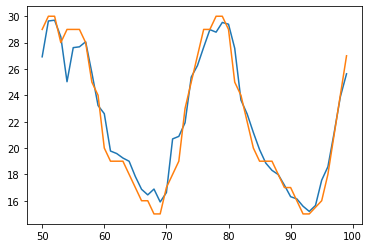

In [ ]:
plt.plot(train_results1['Train Predictions'][50:100])
plt.plot(train_results1['Actuals'][50:100])

In [ ]:
val_predictions1 = model1.predict(X_val1).flatten()
val_results1 = pd.DataFrame(data={'Val Predictions':val_predictions1, 'Actuals':y_val1})
val_results1

,Val Predictions,Actuals
0,28.864370,29.0
1,28.547068,28.0
2,27.807850,28.0
3,27.927811,27.0
4,27.204765,29.0
...,...,...
10093,25.305075,23.0
10094,28.290398,28.0
10095,36.194660,33.0
10096,36.257832,37.0


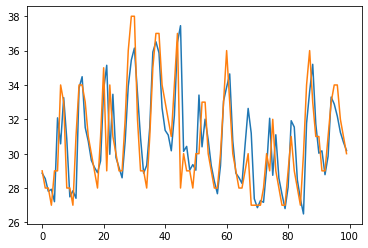

In [ ]:
plt.plot(val_results1['Val Predictions'][:100])
plt.plot(val_results1['Actuals'][:100])

In [ ]:
test_predictions1 = model1.predict(X_test1).flatten()
test_results1 = pd.DataFrame(data={'Test Predictions':test_predictions1, 'Actuals':y_test1})
test_results1

,Test Predictions,Actuals
0,29.435549,32.0
1,28.178562,29.0
2,26.941267,26.0
3,24.186752,24.0
4,27.607990,25.0
...,...,...
10069,35.450218,34.0
10070,37.404396,38.0
10071,38.460533,36.0
10072,31.597095,32.0


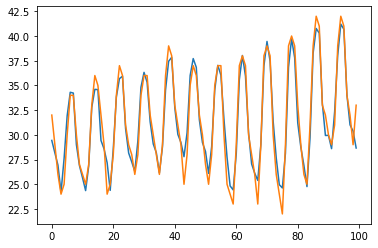

In [ ]:
plt.plot(test_results1['Test Predictions'][:100])
plt.plot(test_results1['Actuals'][:100])


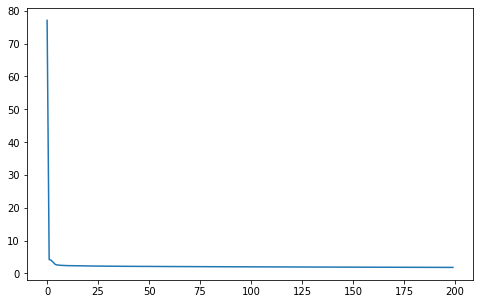

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history1.history['loss'])

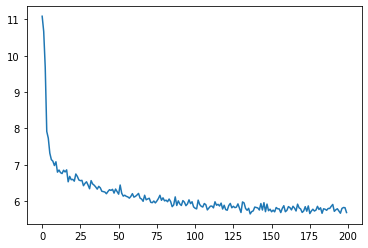

In [ ]:
plt.plot(history1.history['val_loss'])

In [ ]:
def plot_predictions1(model, X, y, start=0, end=100):
  predictions = model.predict(X).flatten()
  df = pd.DataFrame(data={'Predictions':predictions, 'Actuals':y})
  plt.plot(df['Predictions'][start:end])
  plt.plot(df['Actuals'][start:end])
  return df, mse(y, predictions)

(       Predictions  Actuals
 0        29.435549     32.0
 1        28.178562     29.0
 2        26.941267     26.0
 3        24.186752     24.0
 4        27.607990     25.0
 ...            ...      ...
 10069    35.450218     34.0
 10070    37.404396     38.0
 10071    38.460533     36.0
 10072    31.597095     32.0
 10073    29.457588     30.0
 
 [10074 rows x 2 columns], 3.3913358518190506)

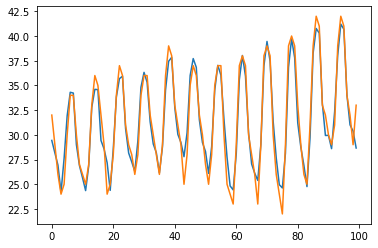

In [ ]:
plot_predictions1(model1, X_test1, y_test1)

# **MODEL 2 - CNN**

In [ ]:
X_train2, y_train2 = X[:80788], y[:80788]
X_val2, y_val2 = X[80788:90886], y[80788:90886]
X_test2, y_test2 = X[90886:], y[90886:]
X_train2.shape, y_train2.shape, X_val2.shape, y_val2.shape, X_test2.shape, y_test2.shape

((80788, 30, 1), (80788,), (10098, 30, 1), (10098,), (10074, 30, 1), (10074,))

In [ ]:
model2 = Sequential()
model2.add(InputLayer((30, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(32, 'relu'))
model2.add(Dense(16, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 flatten (Flatten)           (None, 1856)              0         
                                                                 
 dense_10 (Dense)            (None, 32)                59424     
                                                                 
 dense_11 (Dense)            (None, 16)                528       
                                                                 
 dense_12 (Dense)            (None, 1)                 17        
                                                                 
Total params: 60,161
Trainable params: 60,161
Non-trainable params: 0
_________________________________________________________________


In [ ]:
chp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
history2 = model2.fit(X_train2, y_train2, validation_data=(X_val2, y_val2), epochs=300, callbacks=[chp2])

Epoch 1/300
2525/2525 [==============================] - ETA: 0s - loss: 7.3934 - root_mean_squared_error: 2.7191INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 8s 3ms/step - loss: 7.3934 - root_mean_squared_error: 2.7191 - val_loss: 11.0039 - val_root_mean_squared_error: 3.3172
Epoch 2/300
2504/2525 [============================>.] - ETA: 0s - loss: 3.4362 - root_mean_squared_error: 1.8537INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 9s 4ms/step - loss: 3.4403 - root_mean_squared_error: 1.8548 - val_loss: 10.4095 - val_root_mean_squared_error: 3.2264
Epoch 3/300
2519/2525 [============================>.] - ETA: 0s - loss: 3.2905 - root_mean_squared_error: 1.8140INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 3.2892 - root_mean_squared_error: 1.8136 - val_loss: 9.6264 - val_root_mean_squared_error: 3.1026
Epoch 4/300
2512/2525 [============================>.] - ETA: 0s - loss: 3.1109 - root_mean_squared_error: 1.7638INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 3.1126 - root_mean_squared_error: 1.7643 - val_loss: 9.0324 - val_root_mean_squared_error: 3.0054
Epoch 5/300
2525/2525 [==============================] - 6s 3ms/step - loss: 2.9631 - root_mean_squared_error: 1.7214 - val_loss: 9.2646 - val_root_mean_squared_error: 3.0438
Epoch 6/300
2513/2525 [============================>.] - ETA: 0s - loss: 2.8963 - root_mean_squared_error: 1.7018INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.9027 - root_mean_squared_error: 1.7037 - val_loss: 8.8646 - val_root_mean_squared_error: 2.9774
Epoch 7/300
2518/2525 [============================>.] - ETA: 0s - loss: 2.8506 - root_mean_squared_error: 1.6884INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.8485 - root_mean_squared_error: 1.6878 - val_loss: 8.7947 - val_root_mean_squared_error: 2.9656
Epoch 8/300
2513/2525 [============================>.] - ETA: 0s - loss: 2.7757 - root_mean_squared_error: 1.6660INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.7732 - root_mean_squared_error: 1.6653 - val_loss: 8.5437 - val_root_mean_squared_error: 2.9230
Epoch 9/300
2524/2525 [============================>.] - ETA: 0s - loss: 2.7450 - root_mean_squared_error: 1.6568INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.7447 - root_mean_squared_error: 1.6567 - val_loss: 8.0834 - val_root_mean_squared_error: 2.8431
Epoch 10/300
2524/2525 [============================>.] - ETA: 0s - loss: 2.7141 - root_mean_squared_error: 1.6475INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.7139 - root_mean_squared_error: 1.6474 - val_loss: 7.9348 - val_root_mean_squared_error: 2.8169
Epoch 11/300
2524/2525 [============================>.] - ETA: 0s - loss: 2.6717 - root_mean_squared_error: 1.6345INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.6715 - root_mean_squared_error: 1.6345 - val_loss: 7.9217 - val_root_mean_squared_error: 2.8145
Epoch 12/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.6344 - root_mean_squared_error: 1.6231 - val_loss: 8.3225 - val_root_mean_squared_error: 2.8849
Epoch 13/300
2522/2525 [============================>.] - ETA: 0s - loss: 2.6114 - root_mean_squared_error: 1.6160INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.6119 - root_mean_squared_error: 1.6162 - val_loss: 7.9136 - val_root_mean_squared_error: 2.8131
Epoch 14/300
2509/2525 [============================>.] - ETA: 0s - loss: 2.5754 - root_mean_squared_error: 1.6048INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 8s 3ms/step - loss: 2.5725 - root_mean_squared_error: 1.6039 - val_loss: 7.6400 - val_root_mean_squared_error: 2.7641
Epoch 15/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.5591 - root_mean_squared_error: 1.5997 - val_loss: 7.8539 - val_root_mean_squared_error: 2.8025
Epoch 16/300
2518/2525 [============================>.] - ETA: 0s - loss: 2.5264 - root_mean_squared_error: 1.5895INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.5258 - root_mean_squared_error: 1.5893 - val_loss: 7.4179 - val_root_mean_squared_error: 2.7236
Epoch 17/300
2525/2525 [==============================] - 8s 3ms/step - loss: 2.5255 - root_mean_squared_error: 1.5892 - val_loss: 7.5224 - val_root_mean_squared_error: 2.7427
Epoch 18/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.5104 - root_mean_squared_error: 1.5844 - val_loss: 7.5523 - val_root_mean_squared_error: 2.7481
Epoch 19/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.5103 - root_mean_squared_error: 1.5844 - val_loss: 7.8505 - val_root_mean_squared_error: 2.8019
Epoch 20/300
2514/2525 [============================>.] - ETA: 0s - loss: 2.4770 - root_mean_squared_error: 1.5739INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.4788 - root_mean_squared_error: 1.5744 - val_loss: 7.2985 - val_root_mean_squared_error: 2.7016
Epoch 21/300
2525/2525 [==============================] - 6s 3ms/step - loss: 2.4702 - root_mean_squared_error: 1.5717 - val_loss: 7.6687 - val_root_mean_squared_error: 2.7692
Epoch 22/300
2518/2525 [============================>.] - ETA: 0s - loss: 2.4513 - root_mean_squared_error: 1.5657INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.4511 - root_mean_squared_error: 1.5656 - val_loss: 7.2820 - val_root_mean_squared_error: 2.6985
Epoch 23/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.4461 - root_mean_squared_error: 1.5640 - val_loss: 7.4174 - val_root_mean_squared_error: 2.7235
Epoch 24/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.4350 - root_mean_squared_error: 1.5604 - val_loss: 7.6628 - val_root_mean_squared_error: 2.7682
Epoch 25/300
2507/2525 [============================>.] - ETA: 0s - loss: 2.4308 - root_mean_squared_error: 1.5591INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.4242 - root_mean_squared_error: 1.5570 - val_loss: 7.1538 - val_root_mean_squared_error: 2.6747
Epoch 26/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.4143 - root_mean_squared_error: 1.5538 - val_loss: 7.1797 - val_root_mean_squared_error: 2.6795
Epoch 27/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.4039 - root_mean_squared_error: 1.5504 - val_loss: 7.4555 - val_root_mean_squared_error: 2.7305
Epoch 28/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.4029 - root_mean_squared_error: 1.5501 - val_loss: 7.3851 - val_root_mean_squared_error: 2.7176
Epoch 29/300
2525/2525 [==============================] - 8s 3ms/step - loss: 2.3842 - root_mean_squared_error: 1.5441 - val_loss: 7.4416 - val_root_mean_squared_error: 2.7279
Epoch 30/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.3728 - root_mean_squared_error: 1.5404 - val_loss: 7.

INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.3571 - root_mean_squared_error: 1.5353 - val_loss: 6.9878 - val_root_mean_squared_error: 2.6434
Epoch 33/300
2525/2525 [==============================] - 6s 2ms/step - loss: 2.3536 - root_mean_squared_error: 1.5341 - val_loss: 7.1381 - val_root_mean_squared_error: 2.6717
Epoch 34/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.3383 - root_mean_squared_error: 1.5292 - val_loss: 7.0668 - val_root_mean_squared_error: 2.6583
Epoch 35/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.3324 - root_mean_squared_error: 1.5272 - val_loss: 7.0995 - val_root_mean_squared_error: 2.6645
Epoch 36/300
2518/2525 [============================>.] - ETA: 0s - loss: 2.3323 - root_mean_squared_error: 1.5272INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.3308 - root_mean_squared_error: 1.5267 - val_loss: 6.9386 - val_root_mean_squared_error: 2.6341
Epoch 37/300
2525/2525 [==============================] - 6s 3ms/step - loss: 2.3328 - root_mean_squared_error: 1.5274 - val_loss: 7.0761 - val_root_mean_squared_error: 2.6601
Epoch 38/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.3200 - root_mean_squared_error: 1.5231 - val_loss: 7.5578 - val_root_mean_squared_error: 2.7491
Epoch 39/300
2525/2525 [==============================] - 6s 3ms/step - loss: 2.3163 - root_mean_squared_error: 1.5219 - val_loss: 7.1407 - val_root_mean_squared_error: 2.6722
Epoch 40/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.3129 - root_mean_squared_error: 1.5208 - val_loss: 7.3224 - val_root_mean_squared_error: 2.7060
Epoch 41/300
2525/2525 [==============================] - 6s 3ms/step - loss: 2.3158 - root_mean_squared_error: 1.5218 - val_loss: 7.

INFO:tensorflow:Assets written to: model2/assets


2525/2525 [==============================] - 7s 3ms/step - loss: 2.2095 - root_mean_squared_error: 1.4865 - val_loss: 6.9190 - val_root_mean_squared_error: 2.6304
Epoch 79/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.2083 - root_mean_squared_error: 1.4860 - val_loss: 7.1383 - val_root_mean_squared_error: 2.6718
Epoch 80/300
2525/2525 [==============================] - 6s 3ms/step - loss: 2.2016 - root_mean_squared_error: 1.4838 - val_loss: 7.0022 - val_root_mean_squared_error: 2.6462
Epoch 81/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.2033 - root_mean_squared_error: 1.4843 - val_loss: 6.9482 - val_root_mean_squared_error: 2.6359
Epoch 82/300
2525/2525 [==============================] - 7s 3ms/step - loss: 2.2015 - root_mean_squared_error: 1.4838 - val_loss: 7.0359 - val_root_mean_squared_error: 2.6525
Epoch 83/300
2525/2525 [==============================] - 6s 3ms/step - loss: 2.2005 - root_mean_squared_error: 1.4834 - val_loss: 6.

In [ ]:
model2 = load_model('model2/')

In [ ]:
train_predictions2 = model2.predict(X_train2).flatten()
train_results2 = pd.DataFrame(data={'Train Predictions':train_predictions2, 'Actuals':y_train2})
train_results2

,Train Predictions,Actuals
0,19.843388,19.0
1,18.870419,19.0
2,18.594141,17.0
3,16.864204,17.0
4,16.697338,17.0
...,...,...
80783,28.578369,29.0
80784,27.964298,28.0
80785,28.300032,29.0
80786,30.793602,30.0


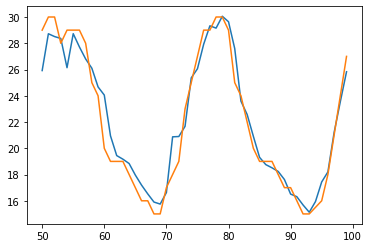

In [ ]:
plt.plot(train_results2['Train Predictions'][50:100])
plt.plot(train_results2['Actuals'][50:100])

In [ ]:
val_predictions2 = model2.predict(X_val2).flatten()
val_results2 = pd.DataFrame(data={'Val Predictions':val_predictions2, 'Actuals':y_val2})
val_results2

,Val Predictions,Actuals
0,30.087584,29.0
1,28.219746,28.0
2,27.714840,28.0
3,27.601707,27.0
4,27.132442,29.0
...,...,...
10093,25.147074,23.0
10094,27.526224,28.0
10095,37.365707,33.0
10096,35.539612,37.0


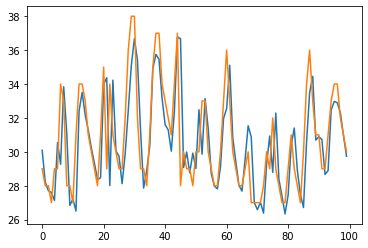

In [ ]:
plt.plot(val_results2['Val Predictions'][:100])
plt.plot(val_results2['Actuals'][:100])

In [ ]:
test_predictions2 = model2.predict(X_test2).flatten()
test_results2 = pd.DataFrame(data={'Test Predictions':test_predictions2, 'Actuals':y_test2})
test_results2

,Test Predictions,Actuals
0,29.918337,32.0
1,28.520813,29.0
2,27.115440,26.0
3,25.002972,24.0
4,27.648104,25.0
...,...,...
10069,31.951691,34.0
10070,34.463432,38.0
10071,36.220341,36.0
10072,31.393917,32.0


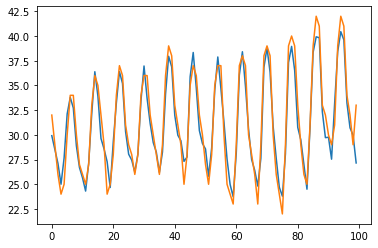

In [ ]:
plt.plot(test_results2['Test Predictions'][:100])
plt.plot(test_results2['Actuals'][:100])

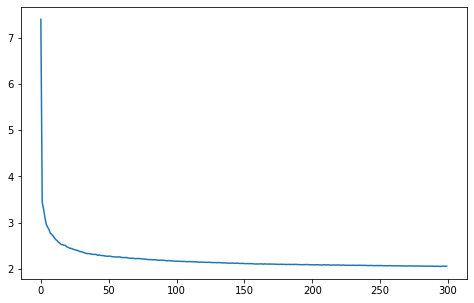

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history2.history['loss'])

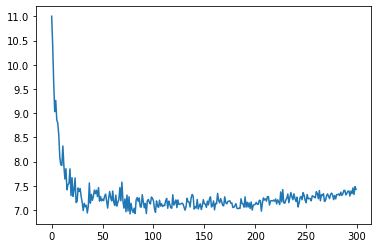

In [ ]:
plt.plot(history2.history['val_loss'])

(       Predictions  Actuals
 0        29.918337     32.0
 1        28.520813     29.0
 2        27.115440     26.0
 3        25.002972     24.0
 4        27.648104     25.0
 ...            ...      ...
 10069    31.951691     34.0
 10070    34.463432     38.0
 10071    36.220341     36.0
 10072    31.393917     32.0
 10073    29.894047     30.0
 
 [10074 rows x 2 columns], 3.9079809454867007)

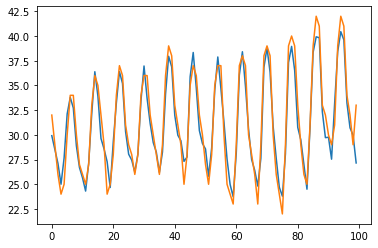

In [ ]:
plot_predictions1(model2, X_test2, y_test2)

# **MODEL 3 - GRU**

In [ ]:
X_train3, y_train3 = X[:80788], y[:80788]
X_val3, y_val3 = X[80788:90886], y[80788:90886]
X_test3, y_test3 = X[90886:], y[90886:]
X_train3.shape, y_train3.shape, X_val3.shape, y_val3.shape, X_test3.shape, y_test3.shape

In [ ]:
model3 = Sequential()
model3.add(InputLayer((30,1)))
model3.add(GRU(64))
model3.add(Dense(32, 'relu'))
model3.add(Dense(32, 'relu'))
model3.add(Dense(16, 'relu'))
model3.add(Dense(1, 'linear'))

model3.summary()

In [ ]:
chp3 = ModelCheckpoint('model3/', save_best_only=True)
model3.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
history3 = model3.fit(X_train3, y_train3, validation_data=(X_val3, y_val3), epochs=11, callbacks=[chp3])

In [ ]:
model3 = load_model('model3/')

In [ ]:
train_predictions3 = model3.predict(X_train3).flatten()
train_results3 = pd.DataFrame(data={'Train Predictions':train_predictions3, 'Actuals':y_train3})
train_results3

In [ ]:
plt.plot(train_results3['Train Predictions'][50:100])
plt.plot(train_results3['Actuals'][50:100])

In [ ]:
val_predictions3 = model3.predict(X_val3).flatten()
val_results3 = pd.DataFrame(data={'Val Predictions':val_predictions3, 'Actuals':y_val3})
val_results3

In [ ]:
plt.plot(val_results3['Val Predictions'][:100])
plt.plot(val_results3['Actuals'][:100])

In [ ]:
test_predictions3 = model3.predict(X_test3).flatten()
test_results3 = pd.DataFrame(data={'Test Predictions':test_predictions3, 'Actuals':y_test3})
test_results3

In [ ]:
plt.plot(test_results3['Test Predictions'][:100])
plt.plot(test_results3['Actuals'][:100])

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history3.history['loss'])

In [ ]:
plt.plot(history3.history['val_loss'])

In [ ]:
plot_predictions1(model3, X_test3, y_test3)

# **MODEL 4 - VREME U DANU I GODINI**

In [ ]:
input_data['datetime_utc']

In [ ]:
temp

In [ ]:
input_data.index = pd.to_datetime(input_data['datetime_utc'], format='%Y%m%d-%H:%M')
input_data[:30]

In [ ]:
temp = input_data[' _tempm']
temp

In [ ]:
temp_data = pd.DataFrame({'Temperature':temp})
temp_data['Seconds'] = temp_data.index.map(pd.Timestamp.timestamp)
temp_data

In [ ]:
day = 60*60*24
year = 365.2425*day

temp_data['Day sin'] = np.sin(temp_data['Seconds']*(2*np.pi/day))
temp_data['Day cos'] = np.cos(temp_data['Seconds']*(2*np.pi/day))
temp_data['Year sin'] = np.sin(temp_data['Seconds']*(2*np.pi/year))
temp_data['Year cos'] = np.cos(temp_data['Seconds']*(2*np.pi/year))

temp_data.head()

In [ ]:
temp_data = temp_data.drop('Seconds', axis=1)
temp_data.head()

In [ ]:
def input_data_to_X_y_2(input, window_size=6):
  input_data_as_np = input.to_numpy()
  X = []
  y = []
  for i in range(len(input_data_as_np)-window_size):
    row = [r for r in input_data_as_np[i:i+window_size]]
    X.append(row)
    label = input_data_as_np[i+window_size][0]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
WINDOW_SIZE2 = 30
X2, y2 = input_data_to_X_y_2(temp_data, WINDOW_SIZE2)
X2.shape, y2.shape

In [ ]:
X2_train, y2_train = X2[:80788], y2[:80788]
X2_val, y2_val = X2[80788:90886], y2[80788:90886]
X2_test, y2_test = X2[90886:], y2[90886:]
X2_train.shape, y2_train.shape, X2_val.shape, y2_val.shape, X2_test.shape, y2_test.shape

In [ ]:
temp_training_mean = np.mean(X2_train[:, :, 0])
temp_training_std = np.std(X2_train[:, :, 0])

def preprocess(X):
  X[:, :, 0] = (X[:, :, 0] - temp_training_mean) / temp_training_std
  return X

In [ ]:
preprocess(X2_train)
preprocess(X2_val)
preprocess(X2_test)

In [ ]:
model4 = Sequential()
model4.add(InputLayer((30, 5)))
model4.add(LSTM(64))
model4.add(Dense(32, 'relu'))
model4.add(Dense(32, 'relu'))
model4.add(Dense(16, 'relu'))
model4.add(Dense(1, 'linear'))

model4.summary()

In [ ]:
chp4 = ModelCheckpoint('model4/', save_best_only=True)
model4.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [ ]:
history4 = model4.fit(X2_train, y2_train, validation_data=(X2_val, y2_val), epochs=100, callbacks=[chp4])

In [ ]:
model4 = load_model('model4/')

In [ ]:
train_predictions4 = model4.predict(X2_train).flatten()
train_results4 = pd.DataFrame(data={'Train Predictions':train_predictions4, 'Actuals':y2_train})
train_results4

In [ ]:
plt.plot(train_results4['Train Predictions'][50:100])
plt.plot(train_results4['Actuals'][50:100])

In [ ]:
val_predictions4 = model4.predict(X2_val).flatten()
val_results4 = pd.DataFrame(data={'Val Predictions':val_predictions4, 'Actuals':y2_val})
val_results4

In [ ]:
plt.plot(val_results4['Val Predictions'][:100])
plt.plot(val_results4['Actuals'][:100])

In [ ]:
test_predictions4 = model4.predict(X2_test).flatten()
test_results4 = pd.DataFrame(data={'Test Predictions':test_predictions4, 'Actuals':y2_test})
test_results4

In [ ]:
plt.plot(test_results4['Test Predictions'][:100])
plt.plot(test_results4['Actuals'][:100])

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(history4.history['loss'])

In [ ]:
plt.plot(history4.history['val_loss'])

In [ ]:
plot_predictions1(model4, X2_test, y2_test)